Text(0, 0.5, 'Output')

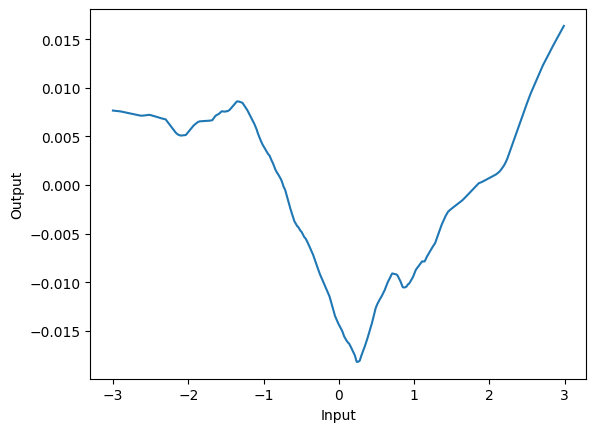

In [10]:
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import transforms,datasets
from torch.utils.data import DataLoader

#set random seed for reproducibility
torch.manual_seed(0)

model = nn.Sequential(nn.Linear(1,100), nn.ReLU(), 
                      nn.Linear(100,100), nn.ReLU(), 
                      nn.Linear(100,100), nn.ReLU(), 
                      nn.Linear(100,1))
opt = optim.SGD(model.parameters(),lr=1e-2)
for _ in range(100):
    loss = nn.MSELoss()(model(torch.randn(100,1)), torch.randn(100,1))
    opt.zero_grad()
    loss.backward()
    opt.step()
                      
plt.plot(np.arange(-3,3,0.01), model(torch.arange(-3,3,0.01)[:,None]).detach().numpy())
plt.xlabel("Input")
plt.ylabel("Output")

Text(0, 0.5, 'Output')

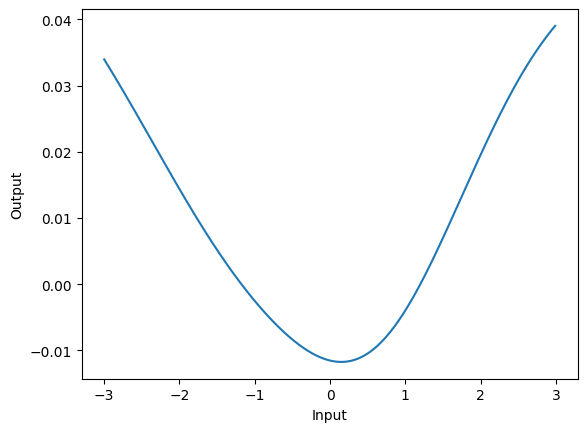

In [3]:
torch.manual_seed(0)

model = nn.Sequential(nn.Linear(1,100), nn.GELU(),
                      nn.Linear(100,100), nn.GELU(),
                      nn.Linear(100,100), nn.GELU(),
                      nn.Linear(100,1))
opt = optim.SGD(model.parameters(),lr=1e-2)
for _ in range(100):
    loss = nn.MSELoss()(model(torch.randn(100,1)), torch.randn(100,1))
    opt.zero_grad()
    loss.backward()
    opt.step()
                      
plt.plot(np.arange(-3,3,0.01), model(torch.arange(-3,3,0.01)[:,None]).detach().numpy())
plt.xlabel("Input")
plt.ylabel("Output")

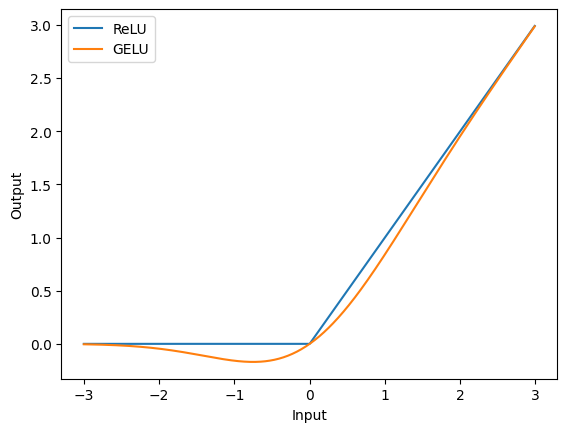

In [4]:
#plot the ReLU and GELU activation functions
plt.plot(np.arange(-3,3,0.01), nn.ReLU()(torch.tensor(np.arange(-3,3,0.01))).numpy())
plt.plot(np.arange(-3,3,0.01), nn.GELU()(torch.tensor(np.arange(-3,3,0.01))).numpy())
plt.xlabel("Input")
plt.ylabel("Output")
plt.legend(["ReLU","GELU"])
plt.show()



In [5]:
device = torch.device("mps" if torch.backends.mps.is_available() else "cuda")

In [11]:
mnist_train = datasets.MNIST("../data", train=True, download=True, transform=transforms.ToTensor())
mnist_test = datasets.MNIST("../data", train=False, download=True, transform=transforms.ToTensor())
train_loader = DataLoader(mnist_train, batch_size = 100, shuffle=True)
test_loader = DataLoader(mnist_test, batch_size = 100, shuffle=False)

In [6]:
def standard_epoch(data_loader, model, loss_fn, optimizer = None):
    epoch_total_loss = 0.0
    epoch_total_correct = 0
    
    for X, y in data_loader:
        #send data to device
        X = X.to(device)
        y = y.to(device)
        
        #get the model prediction
        y_pred = model(X)
        
        #compute loss with respect to the true labels
        loss = loss_fn(y_pred, y)
        
        #if an optimizer is passed, perform a step
        if optimizer:
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
        
        #add the loss to the total loss for the epoch (multiply by the batch size to keep the scale consistent)
        epoch_total_loss += loss.item() * X.shape[0]
        
        #compute the number of correct predictions
        epoch_total_correct += torch.sum(y_pred.argmax(dim=1) == y).item()
        
    #return the average loss and accuracy for the epoch
    return epoch_total_loss / len(data_loader.dataset), epoch_total_correct / len(data_loader.dataset)
        

In [7]:
def adversarial_epoch(data_loader, model, loss_fn, attack_fn, epsilon, optimizer=None, **kwargs):
    epoch_total_loss = 0.0
    epoch_total_correct = 0
    
    for X, y in data_loader:
        #send data to device
        X = X.to(device)
        y = y.to(device)
        
        #generate adversarial perturbation
        delta = attack_fn(model, X, y, loss_fn, epsilon, **kwargs)
        X_adv = X + delta
        
        #get the model prediction on the adversarial example
        y_pred = model(X_adv)
        
        #compute loss with respect to the true labels
        loss = loss_fn(y_pred, y)
        
        #if an optimizer is passed, perform a step
        if optimizer:
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
        
        #add the loss to the total loss for the epoch (multiply by the batch size to keep the scale consistent)
        epoch_total_loss += loss.item() * X.shape[0]
        
        #compute the number of correct predictions
        epoch_total_correct += torch.sum(y_pred.argmax(dim=1) == y).item()
        
    #return the average loss and accuracy for the epoch
    return epoch_total_loss / len(data_loader.dataset), epoch_total_correct / len(data_loader.dataset)

In [8]:
def train_standard_model(model, train_loader, test_loader, loss_fn, optimizer, num_epochs):
    train_losses = []
    test_losses = []
    train_accuracies = []
    test_accuracies = []
    
    print(*(i.format(i) for i in ("Train Loss", "Test Loss", "Train Error", "Test Error")), sep="\t")
    for epoch in range(num_epochs):
        # model.train()
        train_loss, train_accuracy = standard_epoch(train_loader, model, loss_fn, optimizer)
        # model.eval()
        test_loss, test_accuracy = standard_epoch(test_loader, model, loss_fn)
        
        train_losses.append(train_loss)
        test_losses.append(test_loss)
        train_accuracies.append(train_accuracy)
        test_accuracies.append(test_accuracy)
        
        print(*("{:.6f}".format(i) for i in (train_loss, test_loss, train_accuracy, test_accuracy)), sep="\t")
        
    return train_losses, test_losses, train_accuracies, test_accuracies

In [13]:
class Flatten(nn.Module):
    def forward(self, x):
        return x.view(x.shape[0], -1) 

model_cnn_relu = nn.Sequential(nn.Conv2d(1, 32, 3, padding=1), nn.ReLU(),
                          nn.Conv2d(32, 32, 3, padding=1, stride=2), nn.ReLU(),
                          nn.Conv2d(32, 64, 3, padding=1), nn.ReLU(),
                          nn.Conv2d(64, 64, 3, padding=1, stride=2), nn.ReLU(),
                          Flatten(),
                          nn.Linear(7*7*64, 100), nn.ReLU(),
                          nn.Linear(100, 10)).to(device)

relu_optimzier = optim.SGD(model_cnn_relu.parameters(), lr=1e-1)
relu_loss = nn.CrossEntropyLoss()

model_ccn_gelu = nn.Sequential(nn.Conv2d(1, 32, 3, padding=1), nn.GELU(),
                            nn.Conv2d(32, 32, 3, padding=1, stride=2), nn.GELU(),
                            nn.Conv2d(32, 64, 3, padding=1), nn.GELU(),
                            nn.Conv2d(64, 64, 3, padding=1, stride=2), nn.GELU(),
                            Flatten(),
                            nn.Linear(7*7*64, 100), nn.GELU(),
                            nn.Linear(100, 10)).to(device)

gelu_optimizer = optim.SGD(model_ccn_gelu.parameters(), lr=1e-1)
gelu_loss = nn.CrossEntropyLoss()

In [15]:
r_train_losses, r_test_losses, r_train_accuracies, r_test_accuracies = train_standard_model(model_cnn_relu, train_loader, test_loader, relu_loss, relu_optimzier, 10)

Train Loss	Test Loss	Train Error	Test Error
0.079546	0.062634	0.975217	0.979100
0.053125	0.051528	0.983267	0.982800
0.039928	0.046340	0.987767	0.985400
0.031585	0.041491	0.989917	0.986600
0.023772	0.043204	0.992150	0.986500
0.018222	0.048306	0.994333	0.986500
0.016642	0.045550	0.994450	0.985700
0.011682	0.047856	0.996367	0.987800
0.009322	0.051206	0.997133	0.987600
0.010252	0.056697	0.996667	0.987200


In [16]:
g_train_losses, g_test_losses, g_train_accuracies, g_test_accuracies = train_standard_model(model_ccn_gelu, train_loader, test_loader, gelu_loss, gelu_optimizer, 10)

Train Loss	Test Loss	Train Error	Test Error
1.975984	0.190943	0.256633	0.940900
0.121704	0.071487	0.962833	0.974800
0.063246	0.053704	0.980750	0.982100
0.044005	0.043331	0.986200	0.985500
0.032849	0.038713	0.989717	0.987000
0.025102	0.039726	0.992517	0.986700
0.020049	0.041258	0.993883	0.986800
0.016583	0.036553	0.994967	0.988300
0.011682	0.038584	0.996483	0.988100
0.010317	0.042053	0.996833	0.988100


In [17]:
def fgsm(model, X, y, loss_fn, epsilon=0.1):
    """ Construct FGSM adversarial examples on the examples X"""
    delta = torch.zeros_like(X, requires_grad=True)
    loss = loss_fn(model(X + delta), y)
    loss.backward()
    return epsilon * delta.grad.detach().sign()

In [19]:
def evaluate_model_on_adversarial_examples(model, data_loader, loss_fn, attack_fn, epsilon, **kwargs):
    model.eval()
    test_loss, test_accuracy = adversarial_epoch(data_loader, model, loss_fn, attack_fn, epsilon, **kwargs)
    
    return test_loss, test_accuracy

In [20]:
def evaluate_model_accuracy_for_epsilons(model, data_loader, loss_fn, attack_fn, epsilon_values, **kwargs):
    accuracies = []
    
    for epsilon in epsilon_values:
        _, accuracy = evaluate_model_on_adversarial_examples(model, data_loader, loss_fn, attack_fn, epsilon, **kwargs)
        accuracies.append(accuracy)
        
    return accuracies

In [21]:
relu_acc_eps = evaluate_model_accuracy_for_epsilons(model_cnn_relu, test_loader, relu_loss, fgsm, np.linspace(0, 0.3, 10))

In [22]:
gelu_acc_eps = evaluate_model_accuracy_for_epsilons(model_ccn_gelu, test_loader, gelu_loss, fgsm, np.linspace(0, 0.3, 10))

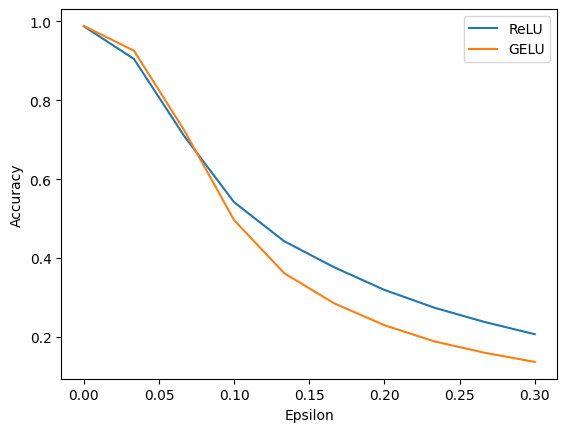

In [23]:
#plot the accuracy of the ReLU and GELU models as a function of epsilon
plt.plot(np.linspace(0, 0.3, 10), relu_acc_eps)
plt.plot(np.linspace(0, 0.3, 10), gelu_acc_eps)
plt.xlabel("Epsilon")
plt.ylabel("Accuracy")
plt.legend(["ReLU", "GELU"])
plt.show()

In [26]:
#define new models to be trained adversarially
model_cnn_relu_adv = nn.Sequential(nn.Conv2d(1, 32, 3, padding=1), nn.ReLU(),
                              nn.Conv2d(32, 32, 3, padding=1, stride=2), nn.ReLU(),
                              nn.Conv2d(32, 64, 3, padding=1), nn.ReLU(),
                              nn.Conv2d(64, 64, 3, padding=1, stride=2), nn.ReLU(),
                              Flatten(),
                              nn.Linear(7*7*64, 100), nn.ReLU(),
                              nn.Linear(100, 10)).to(device)

model_cnn_gelu_adv = nn.Sequential(nn.Conv2d(1, 32, 3, padding=1), nn.GELU(),
                                nn.Conv2d(32, 32, 3, padding=1, stride=2), nn.GELU(),
                                nn.Conv2d(32, 64, 3, padding=1), nn.GELU(),
                                nn.Conv2d(64, 64, 3, padding=1, stride=2), nn.GELU(),
                                Flatten(),
                                nn.Linear(7*7*64, 100), nn.GELU(),
                                nn.Linear(100, 10)).to(device)

relu_optimzier_adv = optim.SGD(model_cnn_relu_adv.parameters(), lr=1e-1)
gelu_optimizer_adv = optim.SGD(model_cnn_gelu_adv.parameters(), lr=1e-1)

In [27]:
def train_robust_model(model, train_loader, test_loader, loss_fn, optimizer, num_epochs, attack_fn, epsilon, **kwargs):
    train_losses = []
    test_losses = []
    adv_losses = []
    train_accuracies = []
    test_accuracies = []
    adv_accuracies = []
    
    print(*(i.format(i) for i in ("Train Loss", "Test Loss", "Adv Loss", "Train Accuracy", "Test Accuracy", "Adv Accuracy")), sep="\t")
    for epoch in range(num_epochs):
        #train the model on adversarial constructed examples
        train_loss, train_accuracy = adversarial_epoch(train_loader, model, loss_fn, attack_fn, epsilon, optimizer, **kwargs)
        #evaluate the model on the test set
        test_loss, test_accuracy = standard_epoch(test_loader, model, loss_fn)
        #evaluate the model on adversarial examples
        adv_loss, adv_accuracy = adversarial_epoch(test_loader, model, loss_fn, attack_fn, epsilon, **kwargs)
        
        train_losses.append(train_loss)
        test_losses.append(test_loss)
        adv_losses.append(adv_loss)
        
        train_accuracies.append(train_accuracy)
        test_accuracies.append(test_accuracy)
        adv_accuracies.append(adv_accuracy)
        
        print(*("{:.6f}".format(i) for i in (train_loss, test_loss, adv_loss, train_accuracy, test_accuracy, adv_accuracy)), sep="\t")
        
    return [train_losses, test_losses, adv_losses, train_accuracies, test_accuracies, adv_accuracies]

In [28]:
#train the ReLU model adversarially
r_train_losses_adv, r_test_losses_adv, r_adv_losses, r_train_accuracies_adv, r_test_accuracies_adv, r_adv_accuracies = train_robust_model(model_cnn_relu_adv, train_loader, test_loader, relu_loss, relu_optimzier_adv, 10, fgsm, 0.1)

Train Loss	Test Loss	Adv Loss	Train Accuracy	Test Accuracy	Adv Accuracy
1.627820	0.157783	0.365741	0.401300	0.953100	0.881300
0.245073	0.053349	0.148396	0.920950	0.983900	0.952100
0.146203	0.045665	0.121036	0.952450	0.985500	0.960600
0.106504	0.039172	0.110179	0.965767	0.987900	0.964700
0.085462	0.032469	0.087628	0.972250	0.989400	0.971700
0.070026	0.030264	0.087166	0.976867	0.990100	0.972700
0.059891	0.027803	0.077367	0.980150	0.990300	0.975900
0.051302	0.027062	0.078326	0.982767	0.990000	0.975700
0.045147	0.026190	0.074357	0.985317	0.991600	0.976700
0.039235	0.029976	0.085145	0.987133	0.990000	0.974100


In [29]:
#train the GELU model adversarially
g_train_losses_adv, g_test_losses_adv, g_adv_losses, g_train_accuracies_adv, g_test_accuracies_adv, g_adv_accuracies = train_robust_model(model_cnn_gelu_adv, train_loader, test_loader, gelu_loss, gelu_optimizer_adv, 10, fgsm, 0.1)

Train Loss	Test Loss	Adv Loss	Train Accuracy	Test Accuracy	Adv Accuracy
2.302685	2.299183	2.300832	0.108183	0.113500	0.113500
1.787153	0.122344	0.361332	0.333500	0.967600	0.882100
0.260447	0.046416	0.174617	0.915883	0.985500	0.942800
0.154790	0.037152	0.137977	0.949217	0.989000	0.954200
0.118140	0.028984	0.113553	0.961500	0.990600	0.962800
0.095493	0.031971	0.121246	0.968067	0.989100	0.959700
0.078457	0.025789	0.099544	0.973733	0.991000	0.968200
0.066412	0.026951	0.104095	0.977967	0.990500	0.967700
0.057877	0.025066	0.094225	0.980867	0.991200	0.970800
0.049175	0.024059	0.089859	0.983867	0.992000	0.972800


In [31]:
relu_acc_eps = evaluate_model_accuracy_for_epsilons(model_cnn_relu_adv, test_loader, relu_loss, fgsm, np.linspace(0, 0.3, 10))

In [32]:
gelu_acc_eps = evaluate_model_accuracy_for_epsilons(model_cnn_gelu_adv, test_loader, gelu_loss, fgsm, np.linspace(0, 0.3, 10))

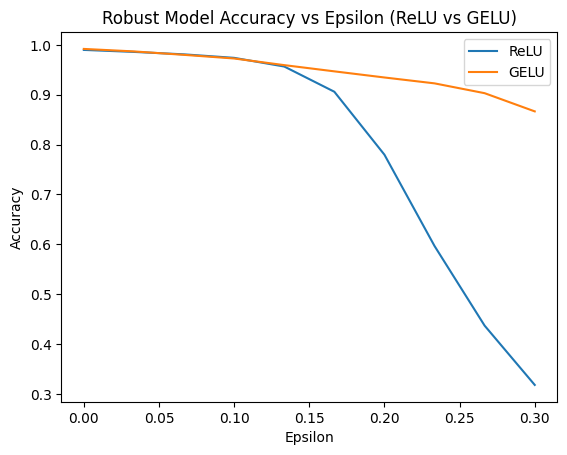

In [34]:
#plot the accuracy of the ReLU and GELU models as a function of epsilon
plt.plot(np.linspace(0, 0.3, 10), relu_acc_eps)
plt.plot(np.linspace(0, 0.3, 10), gelu_acc_eps)
plt.title("Robust Model Accuracy vs Epsilon (ReLU vs GELU)")
plt.xlabel("Epsilon")
plt.ylabel("Accuracy")
plt.legend(["ReLU", "GELU"])
plt.show()

### We can see that using a smooth loss function like GELU tends to help in creating a model that is robust to adversarial attacks.